Title: Thinkful Unit 2 Lesson 3, Naive Bayes
<br>Author: Naomi Hernandez
<br>Date: 2019-04-25

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import os
from glob import glob as glb
import re
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

In [11]:
def make_features(data_frame, metadata, md_col, text_col='text_raw'):
    results = data_frame.copy()
    for r in metadata.index:
        results.loc[:, metadata.loc[r, 'label']] = new[text_col].str.contains(metadata.loc[r, md_col], case=False)
    
    return(results)

In [12]:
def grep_like(patt, x):
    try:
        lst = re.findall(patt, x)
        if len(lst)>0:
            result = lst[0]
        else:
            result=None
        return(result)
    
    except Exception as e:
        print(e)
        return(None)
    
    # re.findall('.*amazon.*', files[0])

In [5]:
path = "H:/Documents/Training/Thinkful/sentiment_labelled_sentences/sls"

In [7]:
files = glb('{}/*.txt'.format(path))

am = list(filter(lambda x: x!= None, map(lambda x: grep_like('.*amazon.*', x), files)))[0]

In [8]:
raw = pd.read_csv(am, sep='\t', header=None, names=['text_raw', 'target'])
raw.head()

,text_raw,target
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


#### Word and case-based features

In [9]:
# Positive and negative key words
neg = [r'no\s*way', 'fooled', 'mislea?d(ing)?', 'problem',
       'unacceptable', 'hate', 'unusable', 'poor', 'disappoint', 
       'n[o\']t *recommend', r'broke(n)?', 'flimsy']
pos = ['good', 'excellent', r'(?<!(not ))great',
       r'(?<!(not ))impressed', r'(?<!(not ))recommend',
       'love', 'best', r'(?<!(not ))ideal', 'high', 'well', 'fine', 'happy', 'delight']

labels = {r'no\s*way': 'no_way', 'mislea?d(ing)?': 'mislead',
        'n[o\']t *recommend': 'not_recommend', r'broke(n)?': 'broken',
       r'(?<!(not ))great': 'great', r'(?<!(not ))impressed': 'impressed',
       r'(?<!(not ))recommend': 'recommend', r'(?<!(not ))ideal': 'ideal'}

In [10]:
# Creating dataframe for labels and keywords to generate nicely labeled columns
md = pd.DataFrame(columns=['positive', 'keyword', 'bkey'])
md.loc[:, 'keyword'] = neg
md.loc[:, 'positive'] = 0

md = pd.concat([md, pd.DataFrame(pos, columns=['keyword'])], sort=False)\
    .reset_index().drop('index', axis=1)
md.loc[md.positive != 0, 'positive'] = 1
md.loc[md.keyword.str.contains(r'[\\s\(\[]'), 'bkey'] = md.keyword.apply(lambda x: r'{0}\b'.format(x))
md.loc[md.bkey.isna(), 'bkey'] = md.keyword.apply(lambda x: r'\b{0}\b'.format(x))
md.loc[:, 'label'] = md.keyword

# Fixing labels
for k in labels:
    md.loc[md.keyword==k, 'label'] = labels[k]

# Create pass from simple labels
md['simple'] = md.label.str.replace('_', ' ').apply(lambda x: r'\b{0}\b'.format(x))

# md

## Investigating error
### Class balance
Since we want to outperform the baseline class distributions, we first need to calculate the relative distributions. As it turns out, our dataset is split exactly 50-50 between our two classes--positive and negative reviews. Any accuracy above 50% is therefore an improvement compared to baseline.

In [128]:
print(raw.target.value_counts().rename({1: 'Positive', 0: 'Negative'}))

Positive    500
Negative    500
Name: target, dtype: int64


## Model 1: Simple keywords
The first iteration of this model uses simple keywords, without taking negation into account.

In [13]:
new = raw[['text_raw', 'target']].copy()

for r in md.index:
    new[md.loc[r, 'label']] = new.text_raw.str.contains(md.loc[r, 'simple'], case=False)

len(new.columns)

27

In [15]:
drp = ['target', 'text_raw']
data = new.drop(drp, axis=1)
target = new.target

In [36]:
from functools import reduce

# Instantiate model and store it in a new variable.
bnb = BernoulliNB()

# Checking accueracy with cross validation, folds=5
cv = cross_val_score(bnb, data, target, cv=5)
print('Mean accuracy using 5 folds: {0}'.format(cv.mean()))
print('Standard deviation using 5 folds: {0}'.format(round(cv.std(), ndigits=3)))
print('Percent improvement from baseline: {0}%'.format(((cv.mean()-0.5)/0.5)*100))
print('Accuracy values: {0}'.format(reduce(lambda x, y: str(x)+', '+str(y), cv)))

Mean accuracy using 5 folds: 0.735
Standard deviation using 5 folds: 0.021
Percent improvement from baseline: 47.0%
Accuracy values: 0.76, 0.755, 0.735, 0.705, 0.72


In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
model = bnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
confus = pd.crosstab(y_test, y_pred).set_index(pd.Index(['True negative', 'True positive'], name=None))
confus.columns = pd.Series(['Predicted negative', 'Predicted positive'], name=None)
confus

,Predicted negative,Predicted positive
True negative,95,0
True positive,51,54


#### Features identifying positive reviews

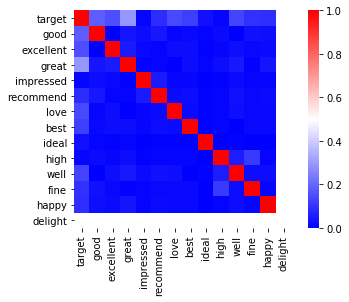

target       1.000000
great        0.293961
good         0.183366
excellent    0.154242
love         0.142857
well         0.136164
best         0.122713
fine         0.097110
happy        0.090496
recommend    0.087976
ideal        0.031639
high         0.014178
impressed    0.010589
delight           NaN
Name: target, dtype: float64

In [133]:
pcorr = new[['target']+list(md.loc[md.positive==1, 'label'])].corr()

sns.heatmap(pcorr.abs(), cmap='bwr', square=True)
plt.show()

pcorr['target'].sort_values(ascending=False)

#### Features identifying negative reviews

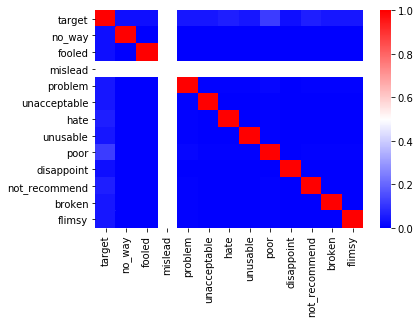

target           1.000000
no_way          -0.031639
fooled          -0.031639
disappoint      -0.031639
problem         -0.044141
broken          -0.044766
unacceptable    -0.044766
flimsy          -0.044766
unusable        -0.044766
hate            -0.063372
not_recommend   -0.063372
poor            -0.119159
mislead               NaN
Name: target, dtype: float64


In [134]:
ncorr = new[['target']+list(md.loc[md.positive==0, 'label'])].corr()
sns.heatmap(ncorr.abs(), cmap='bwr')
plt.show()

print(ncorr['target'].sort_values(ascending=False))

In [142]:
new.loc[new.disappoint==True, 'target'].value_counts()

0    1
Name: target, dtype: int64

## Model 2: Negation and Stems
One place we might have for improvement is to see whether we have any improvement if we try to anticipate negations ('not good' vs. 'good') and some stemming (e.g., mapping 'disappointing' as well as 'disappoint').

In [76]:
negate = make_features(raw[['target', 'text_raw']], md, md_col='bkey')

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the group

In [78]:
data = negate.drop(drp, axis=1)
target = negate.target

In [79]:
# Instantiate model and store it in a new variable.
bnb = BernoulliNB()

# Checking accueracy with cross validation, folds=5
cv = cross_val_score(bnb, data, target, cv=5)
print('Mean accuracy using 5 folds: {0}'.format(cv.mean()))
print('Standard deviation using 5 folds: {0}'.format(round(cv.std(), ndigits=3)))
print('Percent improvement from baseline: {0}%'.format(((cv.mean()-0.5)/0.5)*100))
print('Accuracy values: {0}'.format(reduce(lambda x, y: str(x)+', '+str(y), cv)))

Mean accuracy using 5 folds: 0.744
Standard deviation using 5 folds: 0.024
Percent improvement from baseline: 48.8%
Accuracy values: 0.77, 0.76, 0.755, 0.705, 0.73


Making these corrections to our features only results in an average increase of 1.8% in accuracy. As the confusion matrix demonstrates, this model is much better at identifying negative reviews compared to positive reviews. In fact, it doesn't improve much on the baseline for positive reviews, only correctly identifying approximpately 50% of positive reviews correctly.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
model = bnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
confus = pd.crosstab(y_test, y_pred).set_index(pd.Index(['True negative', 'True positive'], name=None))
confus.columns = pd.Series(['Predicted negative', 'Predicted positive'], name=None)

print('Sensitivity, positive: {0}%'\
      .format(round((confus.loc['True positive', 'Predicted positive']/confus.loc['True positive'].sum())*100, ndigits=1)))
print('Sensitivity, negative: {0}%'\
     .format(round((confus.loc['True negative', 'Predicted negative']/confus.loc['True negative'].sum())*100, ndigits=1)))

Sensitivity, positive: 52.4%
Sensitivity, negative: 100.0%


## Model 3: Only Positive-Identifying Features
I noticed something odd in my data that I'm not sure how to explain. While the terms flagging positive reviews are more highly correlated with the target, both the simple and negation/stemmed model appear to falsely identify positive reviews as negative than the reverse. One possibility is that the absence of the correlated positive terms is interpretted as a negative review. At te same time, negative messages are indeed much less likely to have these terms, but the words occur relatively infrequently even in truly positive messages.

In [95]:
new = raw[['text_raw', 'target']]
pmd = md.loc[md.positive==1]
positive = make_features(new, pmd, 'bkey').drop('text_raw', axis=1)

# Instantiate model and store it in a new variable.
bnb = BernoulliNB()

# Checking accueracy with cross validation, folds=5
cvp = cross_val_score(bnb, positive.drop('target', axis=1), positive.target, cv=5)
print('Mean accuracy using 5 folds: {0}'.format(cvp.mean()))
print('Standard deviation using 5 folds: {0}'.format(round(cvp.std(), ndigits=3)))
print('Percent improvement from baseline: {0}%'.format(((cvp.mean()-0.5)/0.5)*100))
print('Accuracy values: {0}'.format(reduce(lambda x, y: str(x)+', '+str(y), cvp)))

Mean accuracy using 5 folds: 0.744
Standard deviation using 5 folds: 0.024
Percent improvement from baseline: 48.8%
Accuracy values: 0.77, 0.76, 0.755, 0.705, 0.73


C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [105]:
X_train, X_test, y_train, y_test = train_test_split(positive.drop('target', axis=1), positive.target, test_size=0.2, random_state=20)
model = bnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
confus = pd.crosstab(y_test, y_pred).set_index(pd.Index(['True negative', 'True positive'], name=None))
confus.columns = pd.Series(['Predicted negative', 'Predicted positive'], name=None)

print('Sensitivity, positive: {0}%'\
      .format(round((confus.loc['True positive', 'Predicted positive']/confus.loc['True positive'].sum())*100, ndigits=1)))
print('Sensitivity, negative: {0}%'\
     .format(round((confus.loc['True negative', 'Predicted negative']/confus.loc['True negative'].sum())*100, ndigits=1)))

confus

Sensitivity, positive: 52.4%
Sensitivity, negative: 100.0%


,Predicted negative,Predicted positive
True negative,95,0
True positive,50,55


These values are identical to the results of the overall model. We can conclude from this that the negative features do not improve the accuracy of the model at all. But just for good measure, I'm going to test them anyway.

## Model 4: Only negative features
The average accuracy is 54%, approximately the same as the baseline estimate--or flipping a coin, for that matter. We can conclude that our negative features do not improve our model.

In [99]:
new = raw[['target', 'text_raw']]
nmd = md.loc[md.positive==0]
negative = make_features(new, nmd, 'bkey')
ntarget = negative.target
ndata = negative.drop(['text_raw', 'target'], axis=1)

# Instantiate model and store it in a new variable.
bnb = BernoulliNB()

# Checking accueracy with cross validation, folds=5
cvn = cross_val_score(bnb, ndata, ntarget, cv=5)
print('Mean accuracy using 5 folds: {0}'.format(cvn.mean()))
print('Standard deviation using 5 folds: {0}'.format(round(cvn.std(), ndigits=3)))
print('Percent improvement from baseline: {0}%'.format(round(((cvn.mean()-0.5)/0.5)*100, ndigits=1)))
print('Accuracy values: {0}'.format(reduce(lambda x, y: str(x)+', '+str(y), cvn)))

Mean accuracy using 5 folds: 0.542
Standard deviation using 5 folds: 0.009
Percent improvement from baseline: 8.4%
Accuracy values: 0.545, 0.545, 0.555, 0.535, 0.53


C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [104]:
X_train, X_test, y_train, y_test = train_test_split(ndata, ntarget, test_size=0.2, random_state=5)
model = bnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
confus = pd.crosstab(y_test, y_pred).set_index(pd.Index(['True negative', 'True positive'], name=None))
confus.columns = pd.Series(['Predicted negative', 'Predicted positive'], name=None)

print('Sensitivity, positive: {0}%'\
      .format(round((confus.loc['True positive', 'Predicted positive']/confus.loc['True positive'].sum())*100, ndigits=1)))
print('Sensitivity, negative: {0}%'\
     .format(round((confus.loc['True negative', 'Predicted negative']/confus.loc['True negative'].sum())*100, ndigits=1)))

confus

Sensitivity, positive: 99.1%
Sensitivity, negative: 8.8%


,Predicted negative,Predicted positive
True negative,8,83
True positive,1,108


## Model 5: Positive-Identifying Features plus Structural Features
So far I have only focused on word use. I would also like to look at the following structural features:
- *Capitaliztion:* My hypothesis is that more __negative__ reviews contain words in all capitals, or are themselves all capital, than positive reviews.
- *Exclamation points:* My hypothesis is that more __positive__ reviews contain exclamation points compared to negative reviews.
- *Word count:* I could see this going either way. I'm curious to see if this separates negative and positive reviews with any reliability.

### Create structural features

In [132]:
import re
from string import punctuation as pnct

spattern = re.compile(r'\s+')
ppattern = re.compile(r'[{0}]'.format(pnct))

discount = ['I', 'US', 'USB', 'LG', 'Q', 'PDA', 'VX', 'SIM']

In [154]:
m5 = raw[['text_raw', 'target']]

# Strip punctuation and split words
m5['words'] = raw.text_raw.str.replace('[{0}]'.format(pnct), '').apply(lambda x: spattern.split(x))

# For capitalization:
# 1) Filter out words to discount (in 'discount' list)
# 2) Set to true if filtered list length > 0
m5['any_upper'] = m5.words.apply(lambda x:
                                 list(filter(lambda y: y.isupper(), x)))\
        .apply(lambda x: len([y for y in x if y not in discount])>0)

# Find exclamation points
m5['exclaim'] = raw.text_raw.str.contains('!')

# Calculate word count
m5.loc[:, 'words'] = m5.words.apply(lambda x: len(x))

### Explore relationship between new features and target
#### Capitalized words
There is a very slight increase the number of negative reviews that contain capitalized words compared to positive reviews. I doubt this would be sufficient to make a difference in the model, but we'll see. A total difference of nine records, or 0.9% of records, separates negative from positive reviews with respect to capitalization.

In [180]:
up = pd.crosstab(m5.any_upper, m5.target)\
    .set_index(pd.Index(['No uppercase', '1+ uppercase words'], name=None))\
    .rename(pd.Series(['Negative', 'Positive']), axis=1)
up

target,Negative,Positive
No uppercase,448,457
1+ uppercase words,52,43


#### Exclamation points
There is a slightly stronger correlation for exclamation points compared to capitalized words. The difference between the number of positive reviews containing exclamation points compared to the negative reviews containing exclamation points is 4% of the total records compared to the <1% we saw with capitalized words.

In [175]:
exc = pd.crosstab(m5.exclaim, m5.target)\
    .set_index(pd.Index(['No exclamation points', '>=1 exclamation point'], name=None))\
    .rename(pd.Series(['Negative', 'Positive'], name=None), axis=1)

exc

target,Negative,Positive
No exclamation points,463,422
>=1 exclamation point,37,78


#### Number of words per review

In [199]:
m5[['words', 'target']].groupby('target').median()\
    .set_index(pd.Index(['Negative', 'Positive'], name=None))

,words
Negative,10
Positive,8


Since only the presence of an exclamation point appears to correlate in any significant way with the target, that is the only new feature that will be added to the fifth and final model.

### Modeling

In [201]:
pmd = md.loc[md.positive==1]

m5_pos = make_features(m5.drop(['words', 'any_upper'], axis=1), pmd, 'bkey')
target5 = m5_pos.target
data5 = m5_pos.drop(['text_raw', 'target'], axis=1)

# Instantiate model and store it in a new variable.
bnb = BernoulliNB()

# Checking accueracy with cross validation, folds=5
cv5 = cross_val_score(bnb, data5, target5, cv=5)
print('Mean accuracy using 5 folds: {0}'.format(cv5.mean()))
print('Standard deviation using 5 folds: {0}'.format(round(cv5.std(), ndigits=3)))
print('Percent improvement from baseline: {0}%'.format(round(((cv5.mean()-0.5)/0.5)*100, ndigits=1)))
print('Accuracy values: {0}'.format(reduce(lambda x, y: str(x)+', '+str(y), cv5)))

Mean accuracy using 5 folds: 0.734
Standard deviation using 5 folds: 0.029
Percent improvement from baseline: 46.8%
Accuracy values: 0.77, 0.75, 0.75, 0.695, 0.705


C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [202]:
X_train, X_test, y_train, y_test = train_test_split(data5, target5, test_size=0.2, random_state=5)
model = bnb.fit(X_train, y_train)
y_pred = model.predict(X_test)
confus = pd.crosstab(y_test, y_pred).set_index(pd.Index(['True negative', 'True positive'], name=None))
confus.columns = pd.Series(['Predicted negative', 'Predicted positive'], name=None)

print('Sensitivity, positive: {0}%'\
      .format(round((confus.loc['True positive', 'Predicted positive']/confus.loc['True positive'].sum())*100, ndigits=1)))
print('Sensitivity, negative: {0}%'\
     .format(round((confus.loc['True negative', 'Predicted negative']/confus.loc['True negative'].sum())*100, ndigits=1)))

confus

Sensitivity, positive: 56.0%
Sensitivity, negative: 89.0%


,Predicted negative,Predicted positive
True negative,81,10
True positive,48,61


## Conclusion
From an overall accuracy perspective, Model 3 displayed the best performance. However, Model 5 displayed the highest positive review sensititivity. Granted, 56% isn't great, but it's slightly better than the flat 50 - 52% positive sensitivity in the other models. The challenge seems to be that the negative reviews tend to be more specific to the product. Consequently, there are fewer word use trends.